# Classification of Pneumonia, Covid-19, and Normal Chest X-ray Using deep learning models

### imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

### Allow GPU if have

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Defining path to data source

In [3]:
train_data_dir = r'C:\Users\Student\Documents\FA\DS\train'
val_data_dir = r'C:\Users\Student\Documents\FA\DS\val'
test_data_dir = r'C:\Users\Student\Documents\FA\DS\test'

### Hyperparameters or fixed parameters

In [4]:
batch_size = 16 # previously it was 32
input_shape = (256,256,3)
num_classes = 3

### Data Augmentation technique

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [6]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3659 images belonging to 3 classes.
Found 783 images belonging to 3 classes.
Found 786 images belonging to 3 classes.


### Specify the class weights

In [7]:
tot_classes = np.unique(train_generator.classes)
print(tot_classes)
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = tot_classes,
                                        y = train_generator.classes                                                    
                                    )
class_weights = dict(zip(tot_classes, class_weights))
class_weights

[0 1 2]


{0: 1.0717633274751026, 1: 0.9672217816547714, 2: 0.967989417989418}

### Loading base model of VGG19 without the last layers

In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

### Add custom layer of classification

In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

### Defining model

In [10]:
model = Model(inputs=base_model.input, outputs=predictions)

### Avoid previous layers from re-training

In [11]:
for layer in base_model.layers:
    layer.trainable = False

### Print Summary

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

### compile model 

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model_checkpoint = ModelCheckpoint("vgg16_model.h5", save_best_only=True,save_weights_only=False)
model_early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

### Load the save model

In [15]:
#loaded_model = load_model(r'vgg19_model.h5')

In [16]:
#print(loaded_model.history.history)

### Train the model

In [17]:
epochs = 30
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=[model_checkpoint, model_early_stopping])


Epoch 1/30
229/229 [==============================] - 763s 3s/step - loss: 0.5226 - accuracy: 0.7986 - val_loss: 0.4668 - val_accuracy: 0.8161
Epoch 2/30
229/229 [==============================] - 753s 3s/step - loss: 0.3330 - accuracy: 0.8833 - val_loss: 0.2719 - val_accuracy: 0.9080
Epoch 3/30
229/229 [==============================] - 758s 3s/step - loss: 0.2946 - accuracy: 0.8972 - val_loss: 0.3386 - val_accuracy: 0.8621
Epoch 4/30
229/229 [==============================] - 750s 3s/step - loss: 0.2826 - accuracy: 0.9022 - val_loss: 0.4465 - val_accuracy: 0.8250
Epoch 5/30
229/229 [==============================] - 758s 3s/step - loss: 0.2559 - accuracy: 0.9038 - val_loss: 0.3332 - val_accuracy: 0.8812


### Load weights

In [18]:
model.load_weights(r'vgg16_model.h5')

### Moael evaluation on test set

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}%")

50/50 [==============================] - 133s 3s/step - loss: 0.2170 - accuracy: 0.9262
Test Accuracy: 0.93%


### Confusion Matrix

In [20]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix")
print(cm)

50/50 [==============================] - 139s 3s/step
Confusion Matrix
[[244   0   1]
 [  4 267   0]
 [  9  44 217]]


### Visualiza confusion Matrix

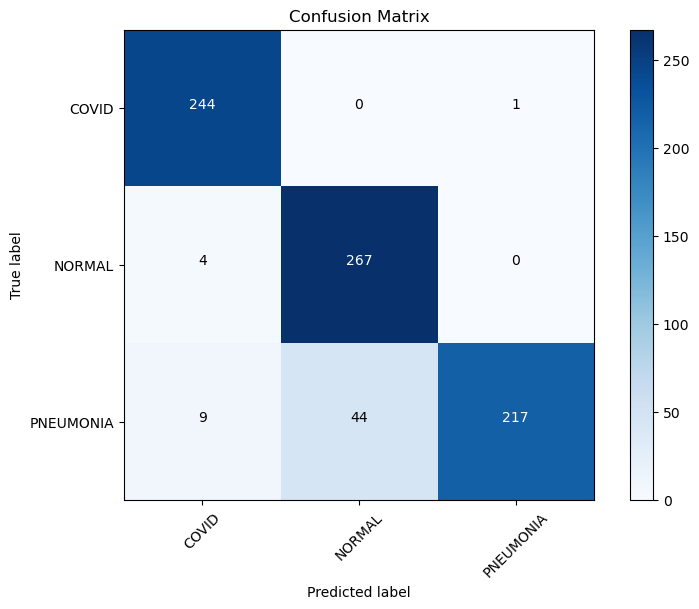

In [21]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = list(test_generator.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Classification Report

In [22]:
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

       COVID       0.95      1.00      0.97       245
      NORMAL       0.86      0.99      0.92       271
   PNEUMONIA       1.00      0.80      0.89       270

    accuracy                           0.93       786
   macro avg       0.93      0.93      0.93       786
weighted avg       0.93      0.93      0.92       786



### visualize classification report

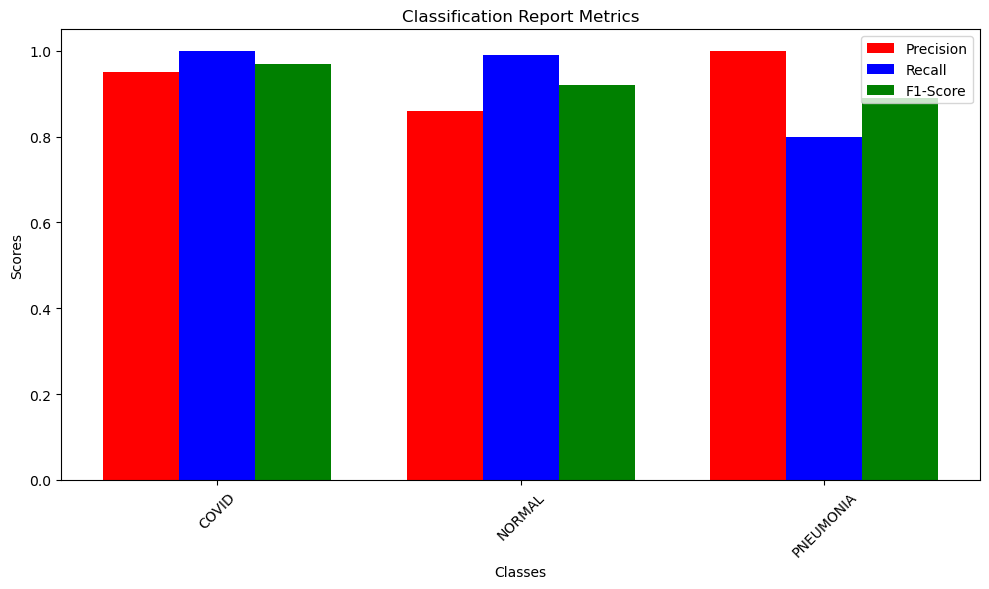

In [23]:
# Visualize the classification report
report_data = class_report.split('\n')
report_data = [data.split() for data in report_data if data]  # Split by spaces

classes = [data[0] for data in report_data[1:-3]]  # Extract classes
precision = [float(data[1]) for data in report_data[1:-3]]  # Extract precision values
recall = [float(data[2]) for data in report_data[1:-3]]  # Extract recall values
f1_score = [float(data[3]) for data in report_data[1:-3]]  # Extract F1-score values

plt.figure(figsize=(10, 6))
bar_width = 0.25
index = range(len(classes))

plt.bar(index, precision, bar_width, color='r', label='Precision')
plt.bar([i + bar_width for i in index], recall, bar_width, color='b', label='Recall')
plt.bar([i + 2 * bar_width for i in index], f1_score, bar_width, color='g', label='F1-Score')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.xticks([i + bar_width for i in index], classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Plots results

In [24]:
#history = loaded_model.history
#print(history.history)

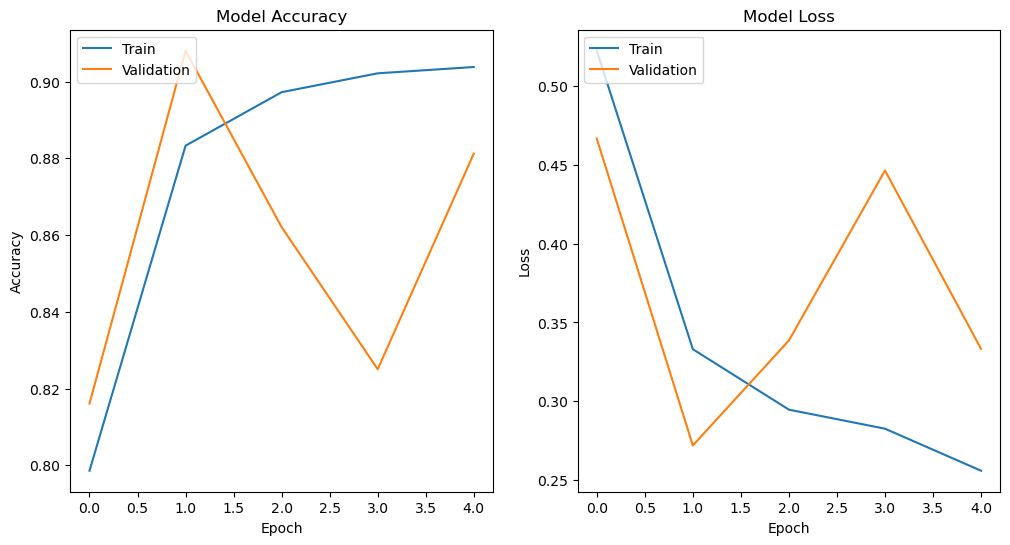

In [25]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()